# Tracker
This notebook tracks long term COVID-19 trends.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
from datetime import datetime, timedelta
from data_mappings import state_full_names
plt.style.use('fivethirtyeight')

In [2]:
states = pd.read_csv("https://covidtracking.com/api/states/daily.csv")
states['date'] = pd.to_datetime(states['date'],format='%Y%m%d')
states['state'] = states['state'].map(state_full_names)
states.rename(columns={
    'death': 'deaths',
    'deathIncrease': 'new_deaths',
    'positive': 'cases',
    'positiveIncrease': 'new_cases',
    'hospitalizedIncrease': 'new_hospitalizations',
    'onVentilatorCurrently': 'on_ventilator',
    'inIcuCurrently': 'in_icu'
},inplace=True)
states = states.sort_values(by=['state','date'])

In [3]:
states.head()

,date,state,cases,negative,pending,hospitalizedCurrently,hospitalizedCumulative,in_icu,inIcuCumulative,on_ventilator,...,posNeg,new_deaths,new_hospitalizations,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
8301,2020-03-07,Alabama,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,603f863240c35c59cc1f0dc72f3627c6b34f6245,0,0,0,0,0,NaN
8251,2020-03-08,Alabama,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0f336cc7f7612532e4e0bb7686c4a4c34d814204,0,0,0,0,0,NaN
8201,2020-03-09,Alabama,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,9a5c5aa1a6409a84174665cc34415dfbe5de44d3,0,0,0,0,0,NaN
8151,2020-03-10,Alabama,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,7163437ee29241a37bcb31ae33c5a14b2168ebe1,0,0,0,0,0,NaN
8101,2020-03-11,Alabama,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10,0,0,09f0e7c8bb6855cd6fc61cd2c24620f52f11c78c,0,0,0,0,0,NaN


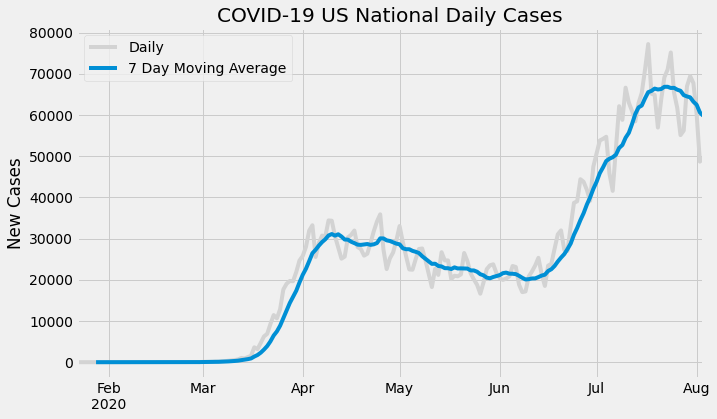

In [70]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
states.groupby('date').new_cases.sum().plot(ax=ax,label='Daily',color='lightgray')
states.groupby('date').new_cases.sum().rolling(7).mean().plot(ax=ax,label='7 Day Moving Average')
ax.set_ylabel('New Cases')
ax.set_xlabel('')
ax.set_title('COVID-19 US National Daily Cases')
ax.legend(loc='upper left');

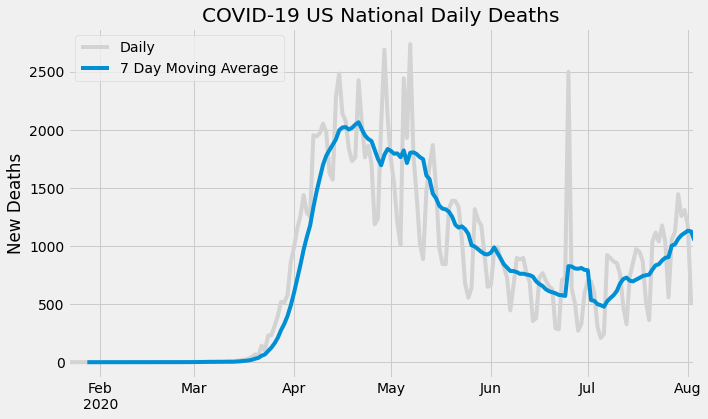

In [71]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
states.groupby('date').new_deaths.sum().plot(ax=ax,label='Daily',color='lightgray')
states.groupby('date').new_deaths.sum().rolling(7).mean().plot(ax=ax,label='7 Day Moving Average')
ax.set_ylabel('New Deaths')
ax.set_xlabel('')
ax.set_title('COVID-19 US National Daily Deaths')
ax.legend(loc='upper left');

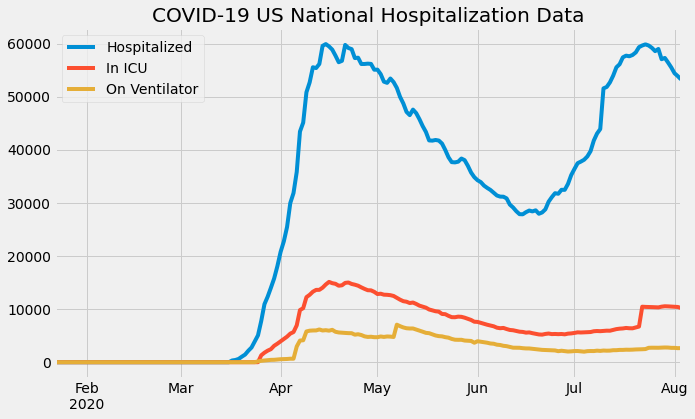

In [73]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
states.groupby('date').hospitalizedCurrently.sum().plot(ax=ax,label='Hospitalized')
states.groupby('date').in_icu.sum().plot(ax=ax,label='In ICU')
states.groupby('date').on_ventilator.sum().plot(ax=ax,label='On Ventilator')
ax.set_title('COVID-19 US National Hospitalization Data')
ax.set_xlabel('')
ax.legend(loc='upper left');

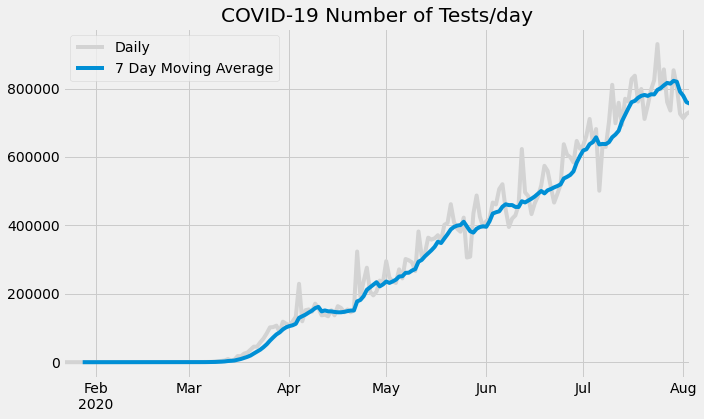

In [74]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
states.groupby('date').totalTestResultsIncrease.sum().plot(ax=ax,label='Daily',color='lightgray')
states.groupby('date').totalTestResultsIncrease.sum().rolling(7).mean().plot(ax=ax,label='7 Day Moving Average')
ax.set_title('COVID-19 Number of Tests/day')
ax.set_xlabel('')
ax.legend(loc='upper left');

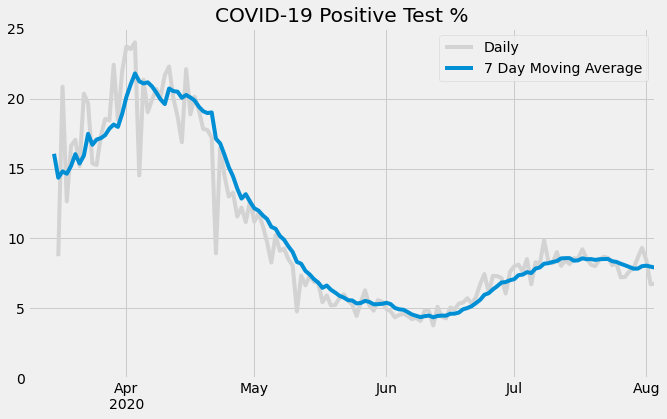

In [76]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
tmp = states.groupby('date')[['negativeIncrease','totalTestResultsIncrease']].sum()

def ptrate(x):
    if x['totalTestResultsIncrease'] != 0:
        return 100*(1 - (x['negativeIncrease']/x['totalTestResultsIncrease']))

tmp['positiveTestPercent'] = tmp.apply(ptrate,axis=1)
tmp.loc[tmp.index > '2020-03-15','positiveTestPercent'].plot(ax=ax,label='Daily',color='lightgray')
tmp.loc[tmp.index > '2020-03-08','positiveTestPercent'].rolling(7).mean().plot(ax=ax,label='7 Day Moving Average')
ax.set_title('COVID-19 Positive Test %')
ax.set_xlabel('')
plt.ylim(0,)
ax.legend(loc='upper right');

In [36]:
for state in states.state:
    states.loc[states.state == state,'new_cases_7d'] = \
        states.loc[states.state == state,'new_cases'].rolling(7).mean()
    states.loc[states.state == state,'new_deaths_7d'] = \
        states.loc[states.state == state,'new_deaths'].rolling(7).mean()
    

In [37]:
for state in states.state:
    states.loc[states.state == state,'delta_cases_14d'] = (
        states.loc[states.state == state,'new_cases_7d'] -
        states.loc[states.state == state,'new_cases_7d'].shift(14)
    )
    states.loc[states.state == state,'delta_deaths_14d'] = (
        states.loc[states.state == state,'new_deaths_7d'] -
        states.loc[states.state == state,'new_deaths_7d'].shift(14)
    )

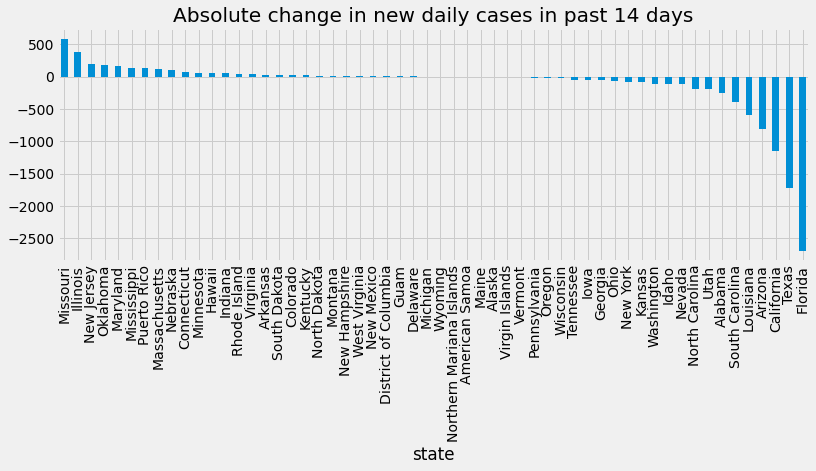

In [79]:
states.groupby('state')\
    .delta_cases_14d.agg('last')\
    .sort_values(ascending=False)\
    .plot.bar(figsize=(12,4))
plt.title('Absolute change in new daily cases in past 14 days');
ax.set_xlabel('')
plt.ylabel('');

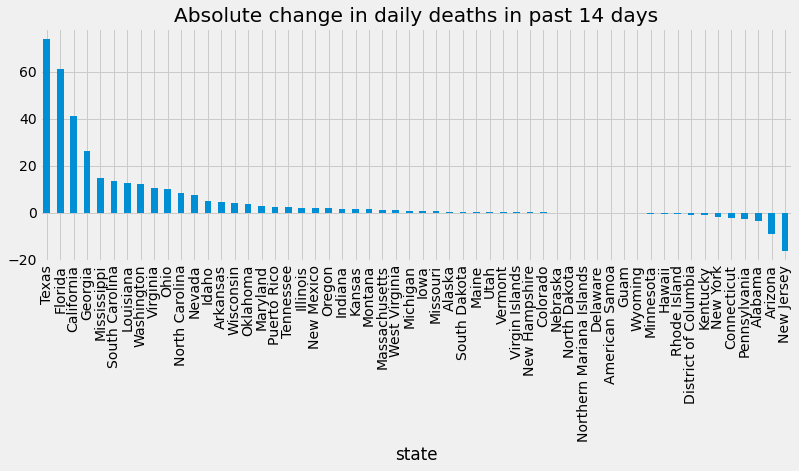

In [78]:
states.groupby('state')\
    .delta_deaths_14d.agg('last')\
    .sort_values(ascending=False)\
    .plot.bar(figsize=(12,4))
plt.title('Absolute change in daily deaths in past 14 days');
ax.set_xlabel('')
plt.ylabel('');

In [93]:
def plot_state(state):
    fig, ax = plt.subplots(1,2,figsize=(12,6))
    states.loc[states.state == state].groupby('date').new_cases.sum().plot(ax=ax[0],label='Daily',color='lightgray')
    states.loc[states.state == state].groupby('date').new_cases.sum().rolling(7).mean().plot(ax=ax[0],label='7 Day Moving Average')
    ax[0].set_title('Daily New Cases in {}'.format(state)); 
    ax[0].set_xlabel('')
    ax[0].legend(loc='upper left')

    states.loc[states.state == state].groupby('date').new_deaths.sum().plot(ax=ax[1],color='lightgray')
    states.loc[states.state == state].groupby('date').new_deaths.sum().rolling(7).mean().plot(ax=ax[1]) 
    ax[1].set_xlabel('')
    ax[1].set_title('Daily Deaths in {}'.format(state));

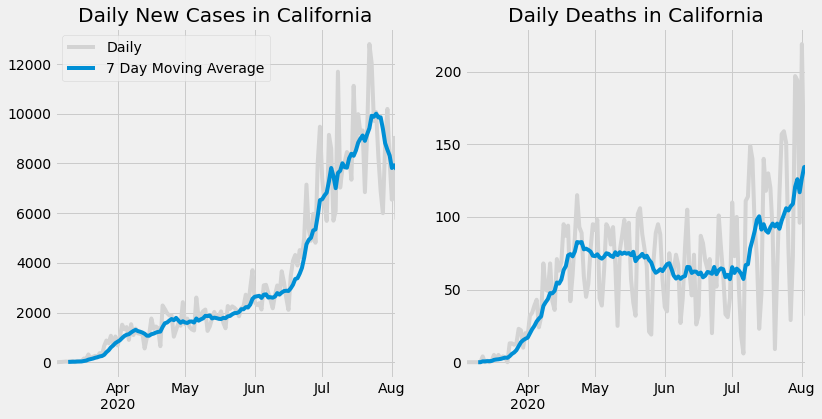

In [94]:
plot_state('California')

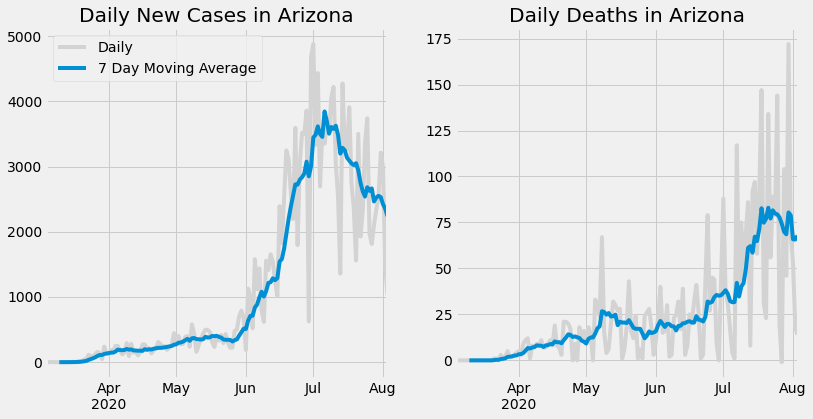

In [95]:
plot_state('Arizona')

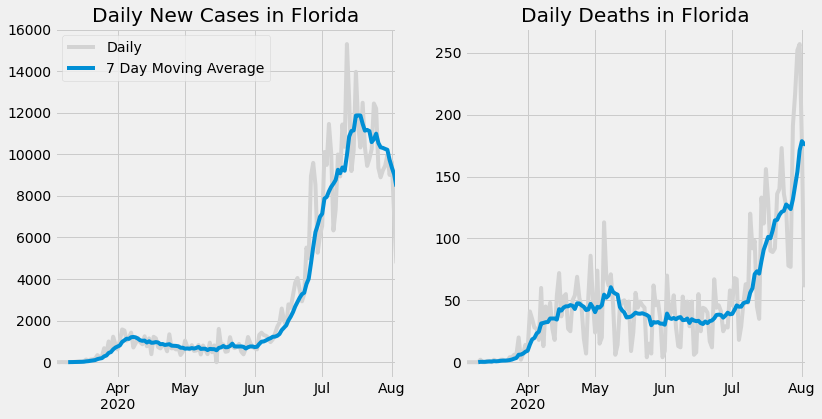

In [96]:
plot_state('Florida')

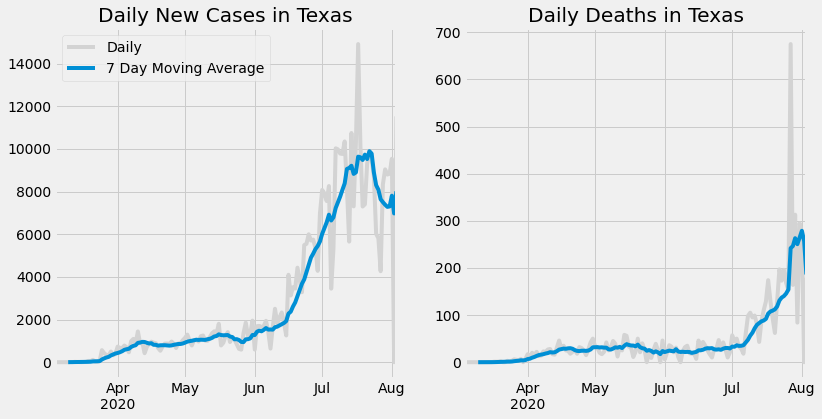

In [97]:
plot_state('Texas')

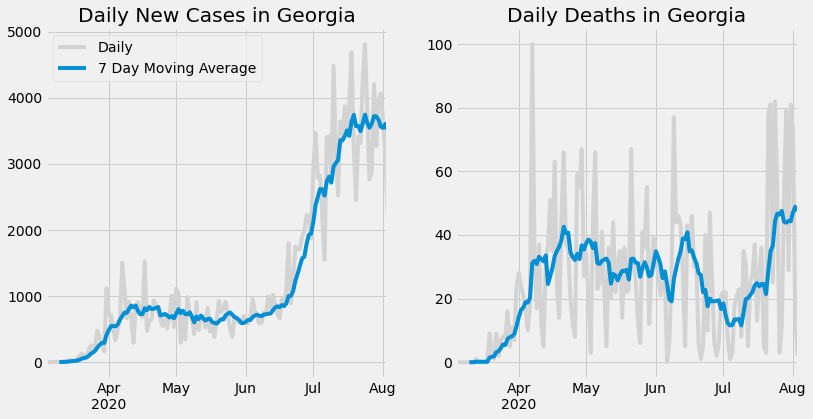

In [99]:
plot_state('Georgia')

## Per Capita Data

In [130]:
perC = pd.pivot_table(states,index='state',values=['cases','deaths'],aggfunc='max')
populations = pd.read_csv('state population and area.csv')[['State','Pop']]
perC = perC.merge(populations,how='inner',left_on='state',right_on='State').set_index('State')
perC['deaths_per_M'] = 1e6 * perC['deaths'] / perC['Pop']
perC['cases_per_K'] = 1e3 * perC['cases'] / perC['Pop']

In [156]:
perC.sort_values(by='deaths_per_M',ascending=False)

,cases,deaths,Pop,deaths_per_M,cases_per_K,ST
State,,,,,,
New Jersey,182614.0,15846.0,8936574,1773.162736,20.434453,NJ
New York,416843.0,25172.0,19440469,1294.824729,21.442024,NY
Connecticut,50062.0,4437.0,3563077,1245.271994,14.050216,CT
Massachusetts,118657.0,8648.0,6976597,1239.572818,17.007862,MA
Rhode Island,19246.0,1010.0,1056161,956.293595,18.222601,RI
Louisiana,120846.0,4024.0,4645184,866.273543,26.015331,LA
District of Columbia,12313.0,586.0,720687,813.113044,17.085087,DC
Michigan,92374.0,6463.0,10045029,643.402821,9.195991,MI
Illinois,184522.0,7723.0,12659682,610.046919,14.575564,IL


In [152]:
# add state abbreviations as a column
state_abbrv = {v: k for k, v in state_full_names.items()}
perC['ST'] = perC.index.map(state_abbrv)

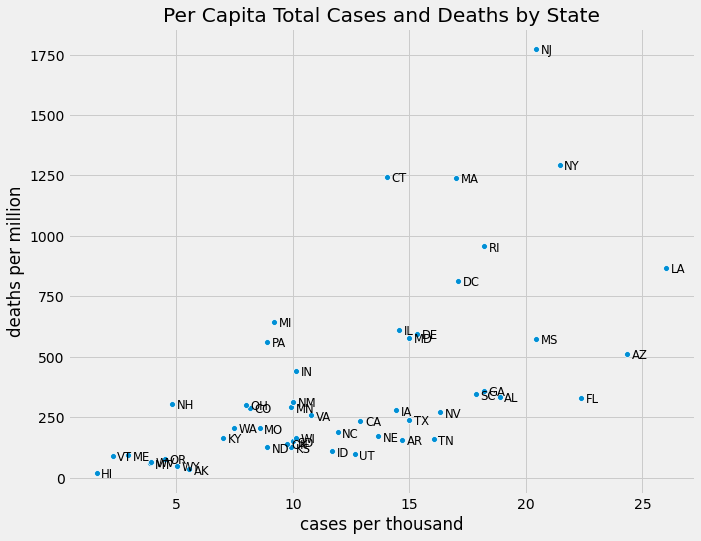

In [162]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
p1 = sns.scatterplot(data=perC,x='cases_per_K',y='deaths_per_M')
ax.set_title('Per Capita Total Cases and Deaths by State')
ax.set_xlabel('cases per thousand')
ax.set_ylabel('deaths per million')

for i in range(0,perC.shape[0]):
     p1.text(perC['cases_per_K'][i]+0.2, perC['deaths_per_M'][i]-20, 
     perC.ST[i], horizontalalignment='left', 
     size='small', color='black')